In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 16,
    })


from fiesta.train.Benchmarker import Benchmarker
from fiesta.inference.lightcurve_model import AfterglowFlux

## Afterglowpy tophat

In [2]:
FILTERS = ["radio-6GHz", "bessellv", "X-ray-5keV"]


model1 = AfterglowFlux("afgpy_tophat",
                        "../surrogates/afgpy_tophat_MLP/", 
                        filters = FILTERS)

model2 = AfterglowFlux("afgpy_tophat",
                        "../surrogates/afgpy_tophat_CVAE/", 
                        filters = FILTERS)


benchmarker1 = Benchmarker(
                    model = model1,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_tophat_raw_data.h5",
                    metric_name = "L2"
                    )

benchmarker2 = Benchmarker(
                    model = model2,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_tophat_raw_data.h5",
                    metric_name = "L2"
                    )

This surrogate afgpy_tophat should only be used in the following parameter ranges:
	 inclination_EM: (0, 1.5707963267948966)
	 log10_E0: (47, 57)
	 thetaCore: (0.01, 0.6283185307179586)
	 log10_n0: (-6, 2)
	 p: (2.01, 3)
	 log10_epsilon_e: (-4, 0)
	 log10_epsilon_B: (-8, 0)
Loaded SurrogateLightcurveModel with filters ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
This surrogate afgpy_tophat should only be used in the following parameter ranges:
	 inclination_EM: (0, 1.5707963267948966)
	 log10_E0: (47, 57)
	 thetaCore: (0.01, 0.6283185307179586)
	 log10_n0: (-6, 2)
	 p: (2.01, 3)
	 log10_epsilon_e: (-4, 0)
	 log10_epsilon_B: (-8, 0)
Loaded SurrogateLightcurveModel with filters ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].


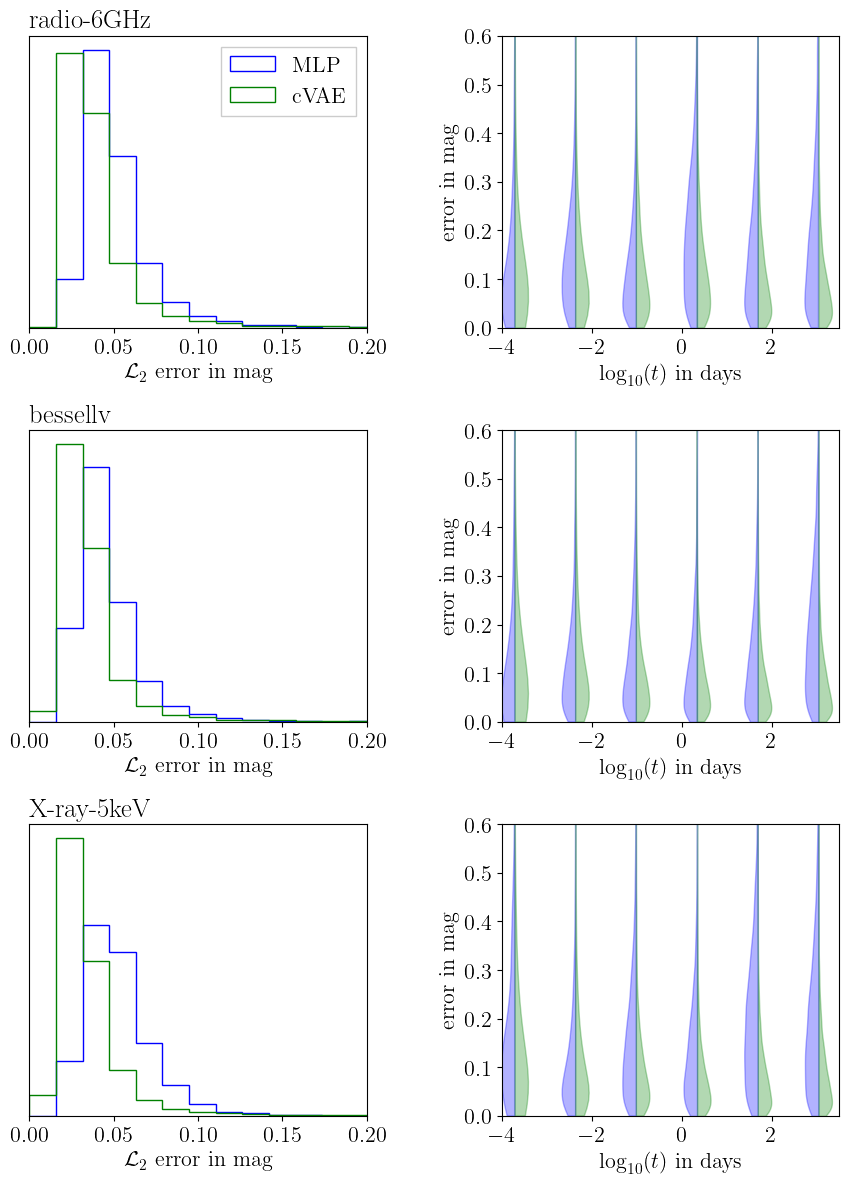

In [3]:
fig, ax = plt.subplots(3, 2, figsize = (9, 12))
fig.subplots_adjust(wspace = 0.4, hspace =0.35, bottom = 0.05, top = 0.95, left = 0.05, right = 0.95)

for filter, cax in zip(FILTERS, ax[:,0]):

    cax.hist(benchmarker1.error[filter], color = "blue", histtype = "step", bins = np.linspace(0, 0.3, 20), density = True, label = "MLP")
    cax.hist(benchmarker2.error[filter], color = "green", histtype = "step", bins = np.linspace(0, 0.3, 20), density = True, label = "cVAE")
    cax.set_yticks([])
    cax.set_xlabel("$\mathcal{L}_2$ error in mag")
    cax.set_xlim((0,0.2))
    cax.set_title(filter, loc = "left")

for filter, cax in zip(FILTERS, ax[:,1]):
    error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model1.times)-10, 6).astype(int)
    parts1 = cax.violinplot(error[:, indices], positions=np.log10(model1.times[indices]), widths=0.6, side="low", showextrema=False, points=500)
    for pc in parts1["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")

    error = np.abs(benchmarker2.pred_mag[filter] - benchmarker2.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model2.times)-10, 6).astype(int)
    parts2 = cax.violinplot(error[:, indices], positions=np.log10(model2.times[indices]), widths=0.6, side="high", showextrema=False, points=500)
    for pc in parts2["bodies"]:
        pc.set_facecolor("green")
        pc.set_edgecolor("green")

    cax.set(xlabel = "$\\log_{10}(t)$ in days", ylabel = "error in mag", xscale = "linear", xlim = (-4., 3.5), ylim = (0,0.6))

ax[0,0].legend(fancybox=False, framealpha=1, fontsize = 16)
fig.savefig("./benchmark_afgpy_tophat.pdf", dpi =300)

## Afterglowpy gaussian

In [4]:
FILTERS = ["radio-6GHz", "bessellv", "X-ray-5keV"]


model1 = AfterglowFlux("afgpy_gaussian",
                        "../surrogates/afgpy_gaussian_MLP/", 
                        filters = FILTERS)

model2 = AfterglowFlux("afgpy_gaussian",
                        "../surrogates/afgpy_gaussian_CVAE/", 
                        filters = FILTERS)


benchmarker1 = Benchmarker(
                    model = model1,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_gaussian_raw_data.h5",
                    metric_name = "L2"
                    )

benchmarker2 = Benchmarker(
                    model = model2,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/afterglowpy_gaussian_raw_data.h5",
                    metric_name = "L2"
                    )

This surrogate afgpy_gaussian should only be used in the following parameter ranges:
	 inclination_EM: (0, 1.5707963267948966)
	 log10_E0: (47, 57)
	 thetaCore: (0.01, 0.6283185307179586)
	 alphaWing: (0.2, 3.5)
	 log10_n0: (-6, 2)
	 p: (2.01, 3)
	 log10_epsilon_e: (-4, 0)
	 log10_epsilon_B: (-8, 0)
Loaded SurrogateLightcurveModel with filters ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
This surrogate afgpy_gaussian should only be used in the following parameter ranges:
	 inclination_EM: (0, 1.5707963267948966)
	 log10_E0: (47, 57)
	 thetaCore: (0.01, 0.6283185307179586)
	 alphaWing: (0.2, 3.5)
	 log10_n0: (-6, 2)
	 p: (2.01, 3)
	 log10_epsilon_e: (-4, 0)
	 log10_epsilon_B: (-8, 0)
Loaded SurrogateLightcurveModel with filters ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].


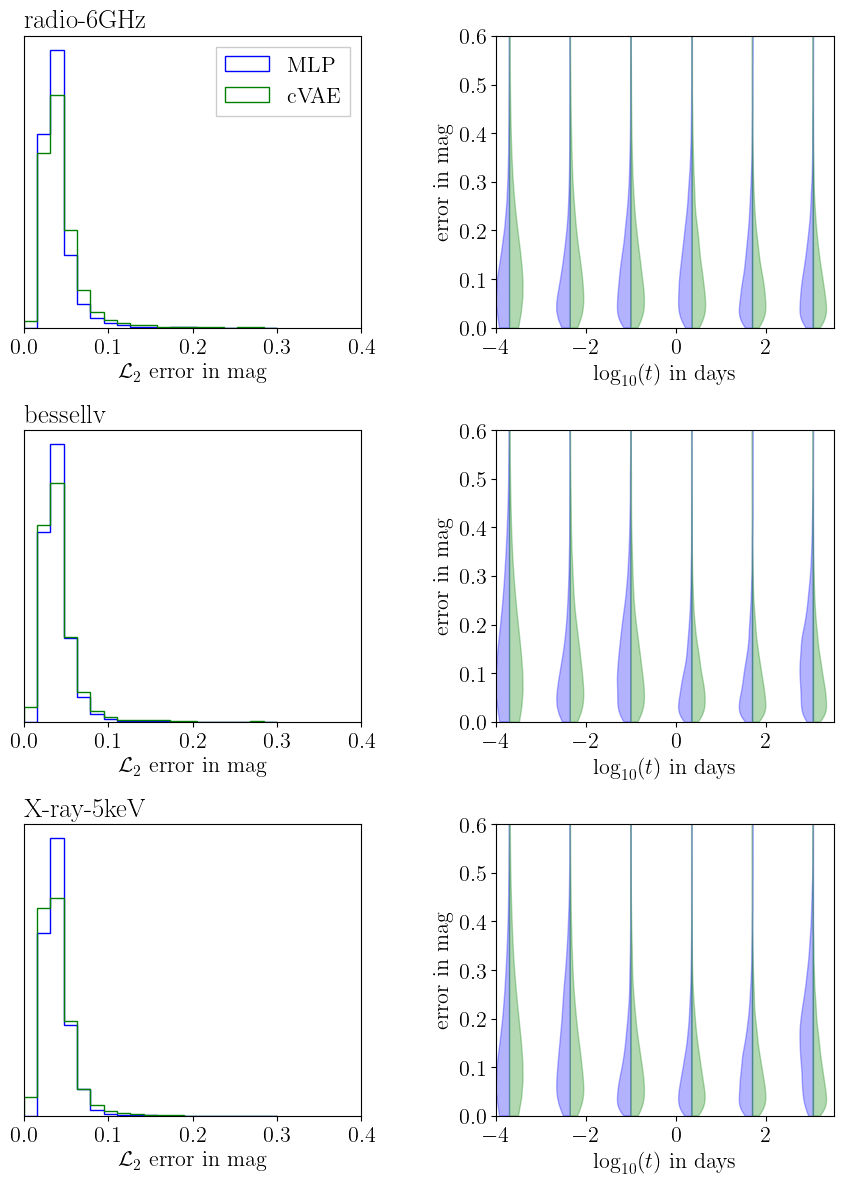

In [7]:
fig, ax = plt.subplots(3, 2, figsize = (9, 12))
fig.subplots_adjust(wspace = 0.4, hspace =0.35, bottom = 0.05, top = 0.95, left = 0.05, right = 0.95)

for filter, cax in zip(FILTERS, ax[:,0]):

    cax.hist(benchmarker1.error[filter], color = "blue", histtype = "step", bins = np.linspace(0, 0.3, 20), density = True, label = "MLP")
    cax.hist(benchmarker2.error[filter], color = "green", histtype = "step", bins = np.linspace(0, 0.3, 20), density = True, label = "cVAE")
    cax.set_yticks([])
    cax.set_xlabel("$\mathcal{L}_2$ error in mag")
    cax.set_xlim((0,0.4))
    cax.set_title(filter, loc = "left")

for filter, cax in zip(FILTERS, ax[:,1]):
    error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model1.times)-10, 6).astype(int)
    parts1 = cax.violinplot(error[:, indices], positions=np.log10(model1.times[indices]), widths=0.6, side="low", showextrema=False, points=500)
    for pc in parts1["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")

    error = np.abs(benchmarker2.pred_mag[filter] - benchmarker2.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model2.times)-10, 6).astype(int)
    parts2 = cax.violinplot(error[:, indices], positions=np.log10(model2.times[indices]), widths=0.6, side="high", showextrema=False, points=500)
    for pc in parts2["bodies"]:
        pc.set_facecolor("green")
        pc.set_edgecolor("green")

    cax.set(xlabel = "$\\log_{10}(t)$ in days", ylabel = "error in mag", xscale = "linear", xlim = (-4., 3.5), ylim = (0,0.6))

ax[0,0].legend(fancybox=False, framealpha=1, fontsize = 16)
fig.savefig("./benchmark_afgpy_gaussian.pdf", dpi =300)

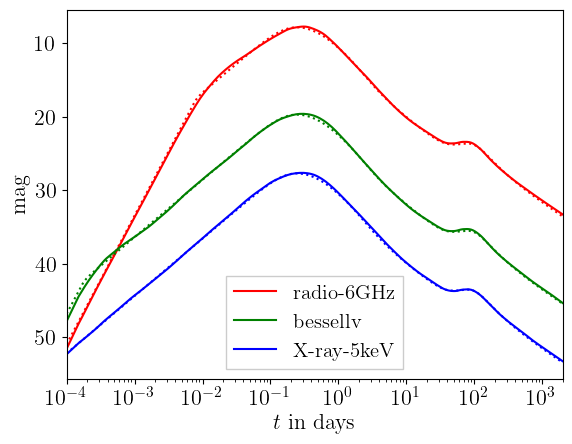

In [6]:
times, pred = model2.predict_abs_mag(dict(zip(model2.parameter_names, benchmarker2.test_X_raw[64])))

for color, filt in zip(["red", "green", "blue"],["radio-6GHz", "bessellv", "X-ray-5keV"]):
    plt.plot(times, pred[filt], color=color, label=filt)
    plt.plot(times, benchmarker2.test_mag[filt][64], linestyle="dotted", color=color)
 

plt.xscale("log")
plt.xlim(1e-4, 2e3)
plt.xlabel("$t$ in days")
plt.ylabel("mag")
plt.gca().invert_yaxis()
plt.plot()
plt.legend(fontsize=15, fancybox=False, framealpha=1)

## Pyblastafterglow gaussian

In [2]:
FILTERS = ["radio-6GHz", "bessellv", "X-ray-5keV"]


model1 = AfterglowFlux("pbag_gaussian",
                        "../surrogates/pbag_gaussian_MLP/", 
                        filters = FILTERS)

model2 = AfterglowFlux("pbag_gaussian",
                        "../surrogates/pbag_gaussian_CVAE/", 
                        filters = FILTERS)


benchmarker1 = Benchmarker(
                    model = model1,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/pyblastafterglow_gaussian_raw_data.h5",
                    metric_name = "L2"
                    )

benchmarker2 = Benchmarker(
                    model = model2,
                    data_file = "/home/aya/work/hkoehn/fiesta/fiesta/surrogates/GRB/training_data/pyblastafterglow_gaussian_raw_data.h5",
                    metric_name = "L2"
                    )

This surrogate pbag_gaussian should only be used in the following parameter ranges:
	 inclination_EM: (0, 1.5707963267948966)
	 log10_E0: (47, 57)
	 thetaCore: (0.01, 0.6283185307179586)
	 alphaWing: (0.2, 3.5)
	 log10_n0: (-6, 2)
	 p: (2.01, 3)
	 log10_epsilon_e: (-4, 0)
	 log10_epsilon_B: (-8, 0)
	 Gamma0: (100, 1000)
Loaded SurrogateLightcurveModel with filters ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
This surrogate pbag_gaussian should only be used in the following parameter ranges:
	 inclination_EM: (0, 1.5707963267948966)
	 log10_E0: (47, 57)
	 thetaCore: (0.01, 0.6283185307179586)
	 alphaWing: (0.2, 3.5)
	 log10_n0: (-6, 2)
	 p: (2.01, 3)
	 log10_epsilon_e: (-4, 0)
	 log10_epsilon_B: (-8, 0)
	 Gamma0: (100, 1000)
Loaded SurrogateLightcurveModel with filters ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].
Loaded filters are: ['radio-6GHz', 'bessellv', 'X-ray-5keV'].


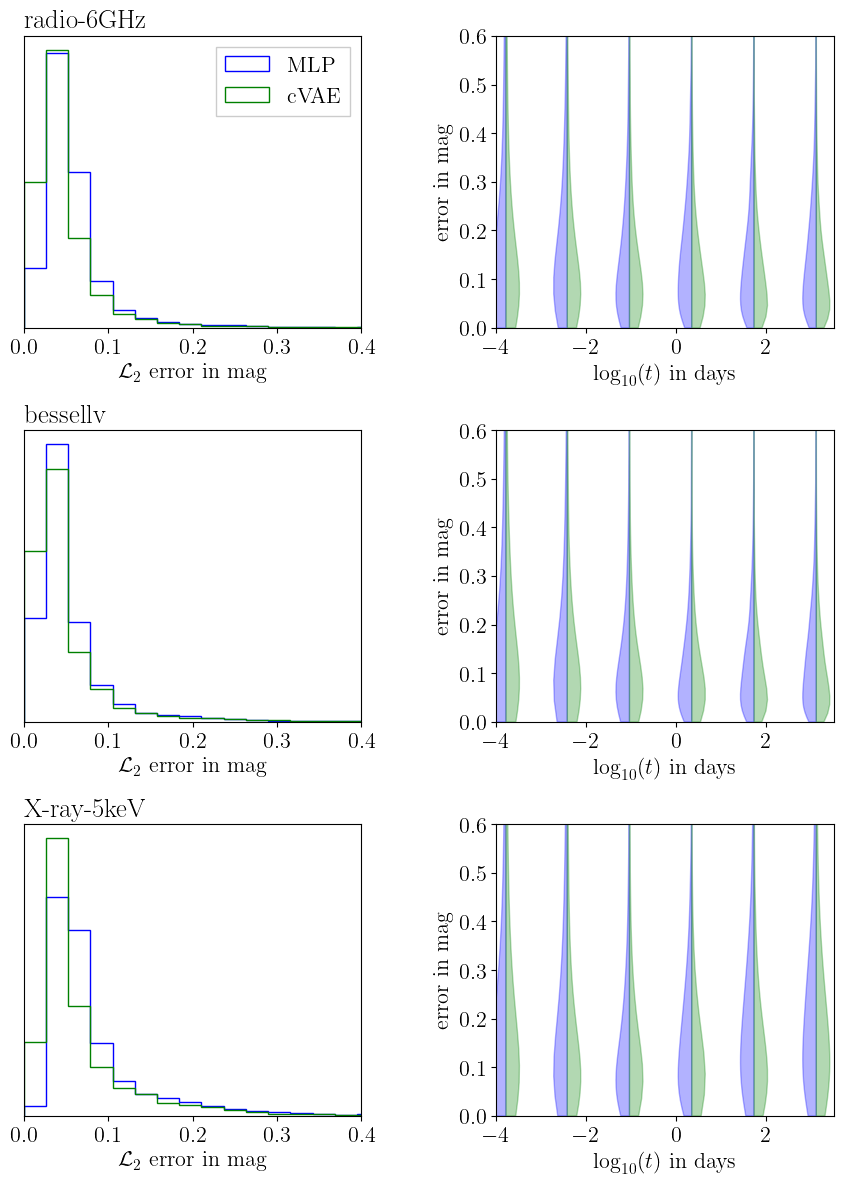

In [3]:
fig, ax = plt.subplots(3, 2, figsize = (9, 12))
fig.subplots_adjust(wspace = 0.4, hspace =0.35, bottom = 0.05, top = 0.95, left = 0.05, right = 0.95)

for filter, cax in zip(FILTERS, ax[:,0]):

    cax.hist(benchmarker1.error[filter], color = "blue", histtype = "step", bins = np.linspace(0, 0.5, 20), density = True, label = "MLP")
    cax.hist(benchmarker2.error[filter], color = "green", histtype = "step", bins = np.linspace(0, 0.5, 20), density = True, label = "cVAE")
    cax.set_yticks([])
    cax.set_xlabel("$\mathcal{L}_2$ error in mag")
    cax.set_xlim((0,0.4))
    cax.set_title(filter, loc = "left")

for filter, cax in zip(FILTERS, ax[:,1]):
    error = np.abs(benchmarker1.pred_mag[filter] - benchmarker1.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model1.times)-10, 6).astype(int)
    parts1 = cax.violinplot(error[:, indices], positions=np.log10(model1.times[indices]), widths=0.6, side="low", showextrema=False, points=500)
    for pc in parts1["bodies"]:
        pc.set_facecolor("blue")
        pc.set_edgecolor("blue")

    error = np.abs(benchmarker2.pred_mag[filter] - benchmarker2.test_mag[filter])
    error[np.isinf(error) | np.isnan(error)] = 0.
    indices = np.linspace(10, len(model2.times)-10, 6).astype(int)
    parts2 = cax.violinplot(error[:, indices], positions=np.log10(model2.times[indices]), widths=0.6, side="high", showextrema=False, points=500)
    for pc in parts2["bodies"]:
        pc.set_facecolor("green")
        pc.set_edgecolor("green")

    cax.set(xlabel = "$\\log_{10}(t)$ in days", ylabel = "error in mag", xscale = "linear", xlim = (-4., 3.5), ylim = (0,0.6))

ax[0,0].legend(fancybox=False, framealpha=1, fontsize = 16)
fig.savefig("./benchmark_pbag_gaussian.pdf", dpi =300)